In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filename = '/content/drive/MyDrive/ucl-sanger_covid_airway.submit_to_czi.cellxgene.20200911.h5ad'
ann = sc.read(filename, backed=None, sheet=None, ext=None, delimiter=None, first_column_names=False, backup_url=None, cache=False)

Only considering the two last: ['.20200911', '.h5ad'].
Only considering the two last: ['.20200911', '.h5ad'].


In [6]:
ann.obs

,SampleID,Age,Sex,Race,Ethnicity,BMI,HeartDisease,LungDisease,KidneyDisease,Diabetes,Hypertension,Immunocompromised,Smoking,SARSCoV2PCR,SARSCoV2Ab,Symptomatic,AdmittedToHospital,RespiratorySupport,RequiredVasoactive,Death28,TypeOfSample,n_counts,n_genes,percent_hb,percent_mito,percent_ribo,percent_top50,Annotation,Institute,ObjectCreateDate
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGCGAC-CV001_KM8853698,AP1-NB,50-60,M,Black,Not Hispanic or Latino,30.0-39.9 (obese),No,No,No,No,Yes,No,Prior,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,21189.0,4816,0.014158,1.873614,8.688471,31.322856,Secretory 1,UCL-SANGER,20200804
AAACCTGCAACACGCC-CV001_KM8853698,AP1-NB,50-60,M,Black,Not Hispanic or Latino,30.0-39.9 (obese),No,No,No,No,Yes,No,Prior,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,9462.0,3532,0.010569,1.754386,11.086452,23.451702,Secretory 1,UCL-SANGER,20200804
AAACCTGCACACGCTG-CV001_KM8853698,AP1-NB,50-60,M,Black,Not Hispanic or Latino,30.0-39.9 (obese),No,No,No,No,Yes,No,Prior,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,2595.0,1345,0.038536,3.121387,9.055877,29.980732,Secretory 1,UCL-SANGER,20200804
AAACCTGTCCTACAGA-CV001_KM8853698,AP1-NB,50-60,M,Black,Not Hispanic or Latino,30.0-39.9 (obese),No,No,No,No,Yes,No,Prior,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,5105.0,2192,0.039177,10.342801,0.705191,38.707150,Secretory 2,UCL-SANGER,20200804
AAACGGGAGTGAAGTT-CV001_KM8853698,AP1-NB,50-60,M,Black,Not Hispanic or Latino,30.0-39.9 (obese),No,No,No,No,Yes,No,Prior,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,1789.0,1055,0.055897,0.279486,5.869201,29.122415,Secretory 1,UCL-SANGER,20200804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGACAAGC-CV001_KM8854513,AP5-NB,50-60,F,Asian,Not Hispanic or Latino,Unknown,No,No,No,No,No,No,Never or unknown,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,3295.0,1868,0.000000,2.579666,7.162367,21.274659,Ciliated 1,UCL-SANGER,20200804
TTTGTCATCAGATAAG-CV001_KM8854513,AP5-NB,50-60,F,Asian,Not Hispanic or Latino,Unknown,No,No,No,No,No,No,Never or unknown,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,8014.0,2787,0.024956,1.734465,7.686549,31.707013,Secretory 3,UCL-SANGER,20200804
TTTGTCATCAGCTCTC-CV001_KM8854513,AP5-NB,50-60,F,Asian,Not Hispanic or Latino,Unknown,No,No,No,No,No,No,Never or unknown,Positve,Not Done,Yes,Yes,"Non-invasive ventilation (CPAP, BiPAP, HFNC)",No,No,Nasal brush,6386.0,2812,0.015659,1.424992,6.921391,24.851237,Ciliated 1,UCL-SANGER,20200804


In [7]:
ann.obs.RespiratorySupport.unique()

['Non-invasive ventilation (CPAP, BiPAP, HFNC)', 'None']
Categories (2, object): ['Non-invasive ventilation (CPAP, BiPAP, HFNC)', 'None']

In [8]:
#Covid dataset
covid = ann[ann.obs["SARSCoV2PCR"] == "Positve", :]
nocovid = ann[ann.obs["SARSCoV2PCR"] == "Negative", :]




In [9]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.1 leidenalg==0.8.3


In [10]:
ann.obs.Annotation.unique()

['Secretory 1', 'Secretory 2', 'Basal cycling', 'Basal', 'Ciliated 2', ..., 'DCs', 'Mast', 'Monocytes', 'Macrophages', 'B']
Length: 18
Categories (18, object): ['Secretory 1', 'Secretory 2', 'Basal cycling', 'Basal', ..., 'Mast',
                          'Monocytes', 'Macrophages', 'B']

normalizing counts per cell
    finished (0:00:00)


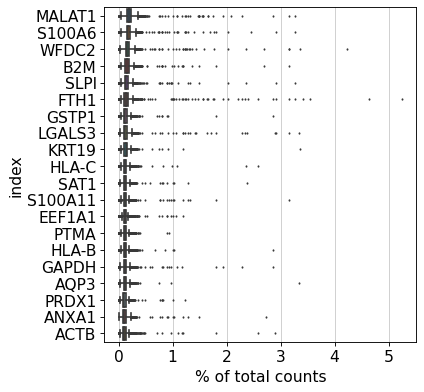

In [11]:
sc.pl.highest_expr_genes(ann, n_top=20, )

In [12]:
sc.pp.filter_cells(ann, min_genes=200)
sc.pp.filter_genes(ann, min_cells=3)

filtered out 51 cells that have less than 200 genes expressed
filtered out 12452 genes that are detected in less than 3 cells


In [13]:
ann.var['mt'] = ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

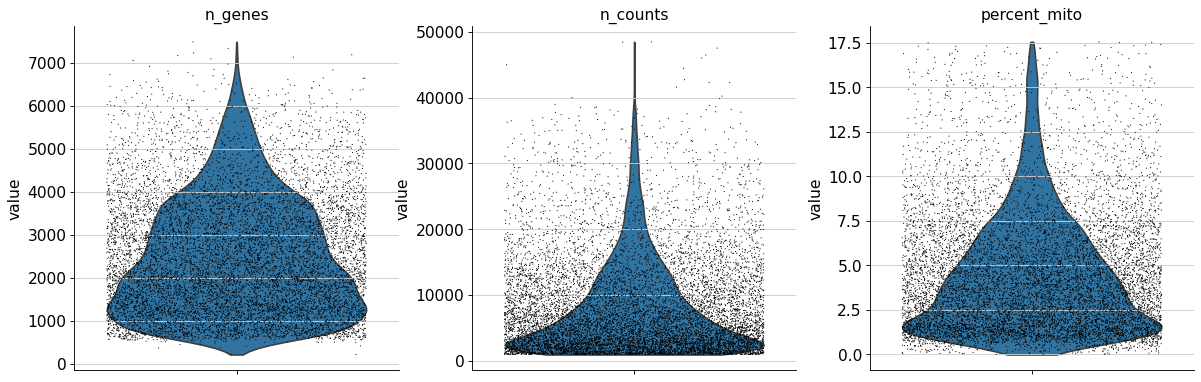

In [14]:
sc.pl.violin(ann, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

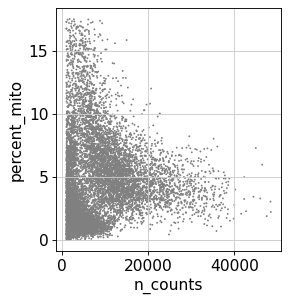

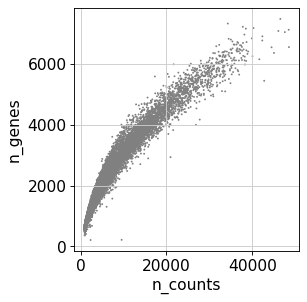

In [15]:
sc.pl.scatter(ann, x='n_counts', y='percent_mito')
sc.pl.scatter(ann, x='n_counts', y='n_genes')

In [16]:
ann = ann[ann.obs.n_genes < 2500, :]
ann = ann[ann.obs.percent_mito < 5, :]

In [17]:
sc.pp.normalize_total(ann, target_sum=1e4)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


In [19]:
sc.pp.log1p(ann)

In [20]:
sc.pp.highly_variable_genes(ann, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


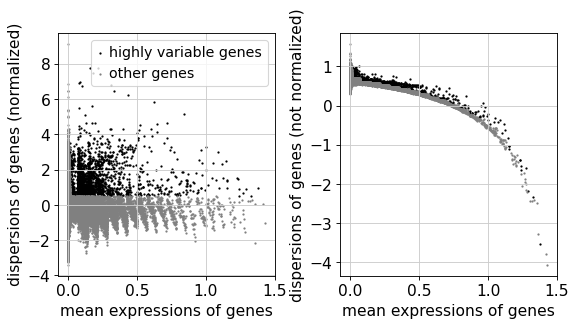

In [21]:
sc.pl.highly_variable_genes(ann)

In [22]:
ann.raw = ann

In [23]:
ann = ann[:, ann.var.highly_variable]

In [24]:
sc.pp.regress_out(ann, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:16)


In [25]:
sc.pp.scale(ann, max_value=10)

In [26]:
sc.tl.pca(ann, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


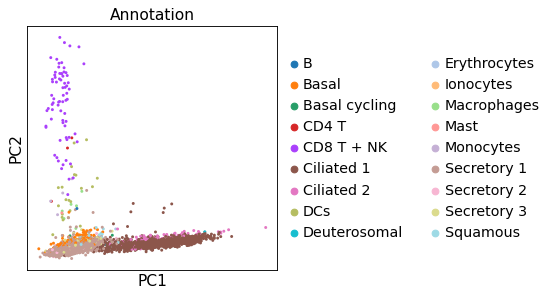

In [27]:
sc.pl.pca(ann, color='Annotation')

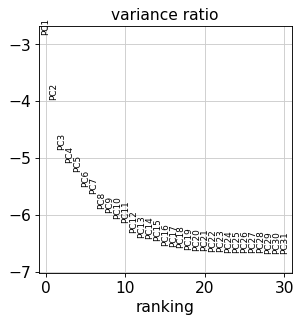

In [28]:
sc.pl.pca_variance_ratio(ann, log=True)

In [29]:
ann

AnnData object with n_obs × n_vars = 4265 × 2344
    obs: 'SampleID', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'HeartDisease', 'LungDisease', 'KidneyDisease', 'Diabetes', 'Hypertension', 'Immunocompromised', 'Smoking', 'SARSCoV2PCR', 'SARSCoV2Ab', 'Symptomatic', 'AdmittedToHospital', 'RespiratorySupport', 'RequiredVasoactive', 'Death28', 'TypeOfSample', 'n_counts', 'n_genes', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'Annotation', 'Institute', 'ObjectCreateDate', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'Annotation_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'

In [30]:
sc.pp.neighbors(ann) 
# , n_neighbors=10, n_pcs=40

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [31]:
sc.tl.umap(ann,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


Clustering the neighborhood graph

In [32]:
sc.tl.leiden(ann)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


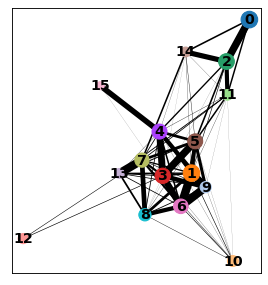

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [33]:
sc.tl.paga(ann)
sc.pl.paga(ann, )  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(ann, init_pos='paga' )

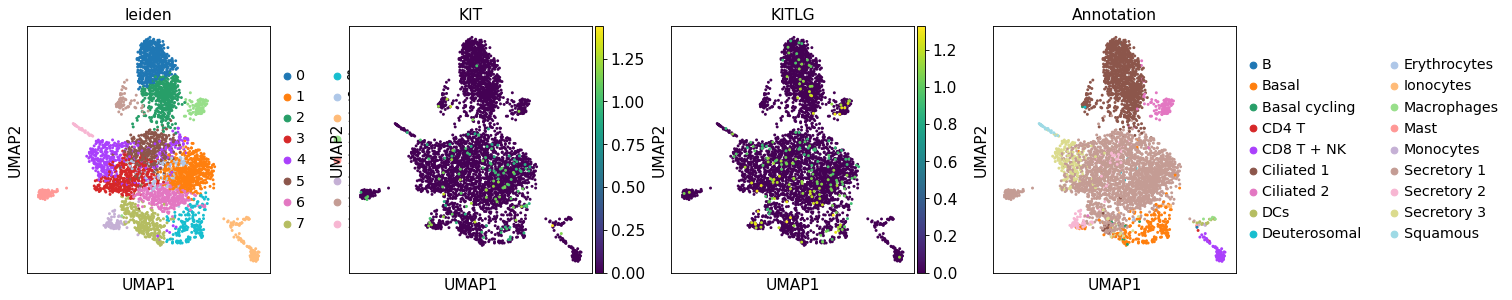

In [34]:
sc.pl.umap(ann, color=['leiden', 'KIT', 'KITLG', 'Annotation'])

**Finding marker genes**
ranking for the highly differential genes in each cluster

In [35]:
sc.settings.verbosity = 2  # reduce the verbosity

In [36]:
#Exclude from dataset Annotations with unique values
pvls = ann[~ann.obs['Annotation'].isin(['B','Mast']) ]

In [37]:
pvls.obs['Annotation'].unique()

['Secretory 1', 'Basal cycling', 'Ciliated 2', 'Secretory 2', 'Basal', ..., 'Ionocytes', 'DCs', 'Deuterosomal', 'Monocytes', 'Macrophages']
Length: 16
Categories (16, object): ['Secretory 1', 'Basal cycling', 'Ciliated 2', 'Secretory 2', ..., 'DCs',
                          'Deuterosomal', 'Monocytes', 'Macrophages']

ranking genes
Trying to set attribute `.uns` of view, copying.
    finished (0:00:06)


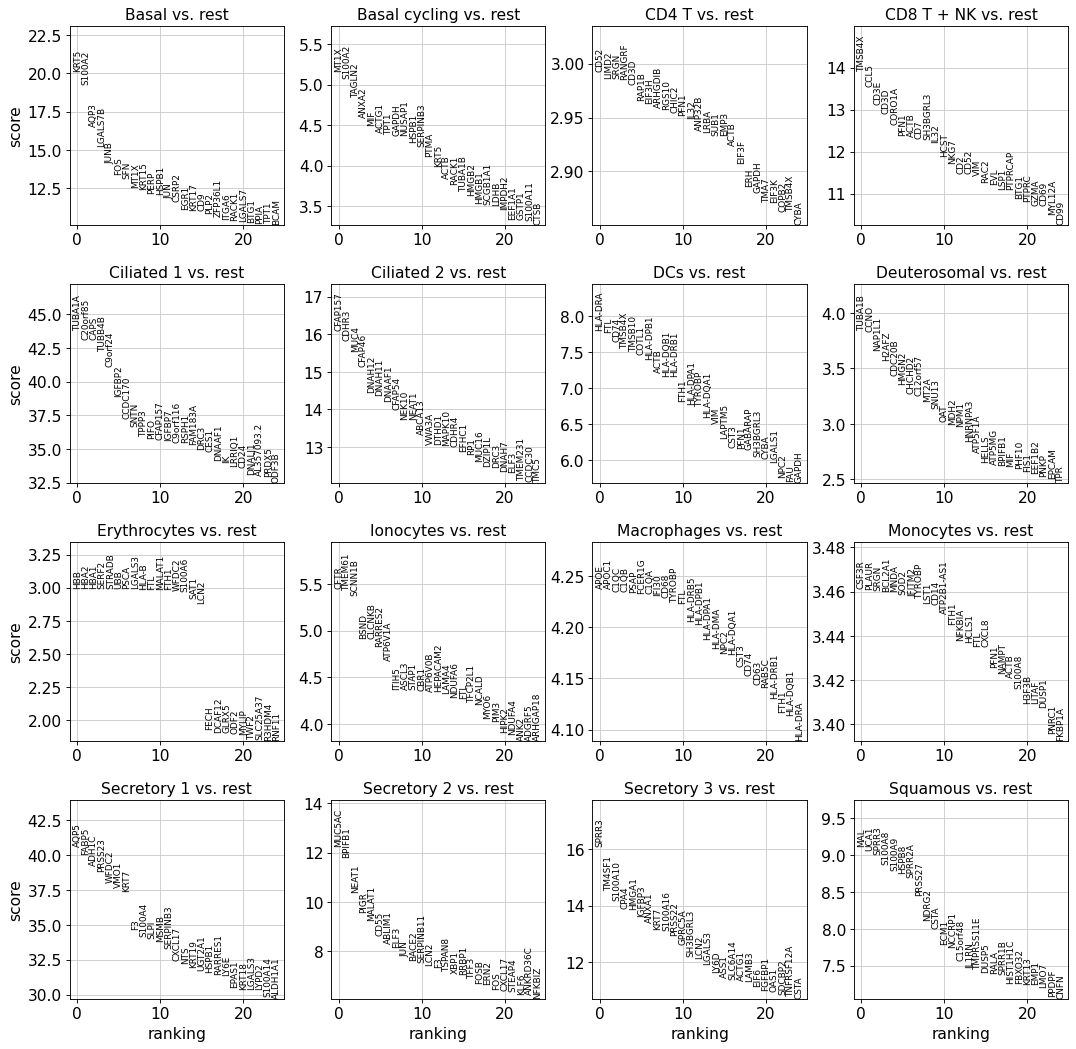

In [38]:
#Wilcoxon rank-sum (Mann-Whitney-U) test

sc.tl.rank_genes_groups(pvls, 'Annotation', method='wilcoxon')
sc.pl.rank_genes_groups(pvls, n_genes=25, sharey=False)

In [39]:
result = pvls.uns['rank_genes_groups']
groups = result['names'].dtype.names
expr = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

In [41]:
names  =[]
pvals = []
pvals_adj = []
logFC = []

for i in range(len(result['names'])):
  for name in result['names'][i]:
      names.append(name)
  for pval in result['pvals'][i]:
      pvals.append(pval)
  for pval_adj in result['pvals_adj'][i]:
      pvals_adj.append(pval_adj)
  for fc in result['logfoldchanges'][i]:
      logFC.append(fc)

wilcoxon = pd.DataFrame(
    {'genes': names,
     'pvals': pvals,
     'pvals_adj': pvals_adj,
     'logFC': logFC
    })


In [42]:
#Simple check for statistical inference in genes we interested in
wilcoxon[wilcoxon['genes'].isin(['KIT', 'KITLG'] )]

,genes,pvals,pvals_adj,logFC
2025,KIT,0.009583,1.000000,4.556742
13437,KITLG,0.259149,1.000000,1.440893
31040,KITLG,0.322866,1.000000,1.020945
31173,KITLG,0.498097,1.000000,1.064254
38368,KIT,0.434375,1.000000,1.042778
52365,KIT,0.788793,1.000000,0.686120
54988,KIT,0.229951,0.815603,1.152701
65471,KITLG,0.816293,1.000000,0.597979
71212,KITLG,0.499393,1.000000,0.326865
83599,KIT,0.953993,1.000000,0.167531


ranking genes
    finished (0:00:01)


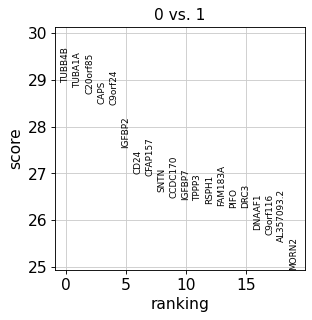

In [43]:
#Compare to a single cluster

sc.tl.rank_genes_groups(ann, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(ann, groups=['0'], n_genes=20)

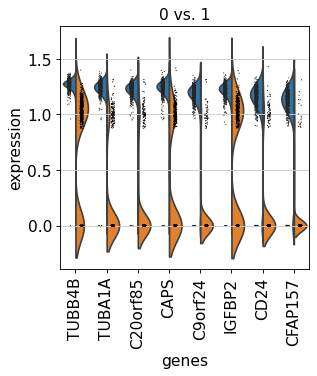

In [44]:
sc.pl.rank_genes_groups_violin(ann, groups='0', n_genes=8)

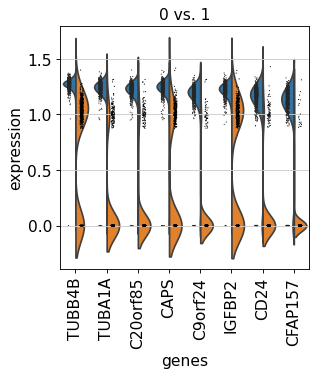

In [45]:
sc.pl.rank_genes_groups_violin(ann, groups='0', n_genes=8)

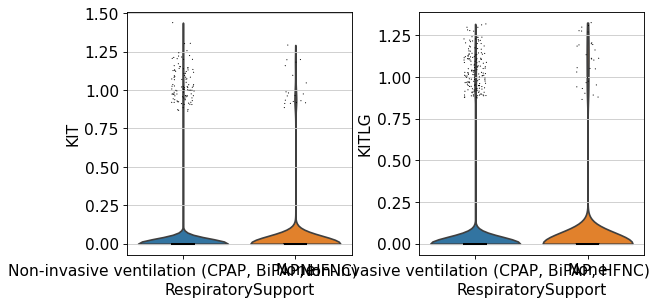

In [46]:
sc.pl.violin(ann, ['KIT', 'KITLG'], groupby='RespiratorySupport')

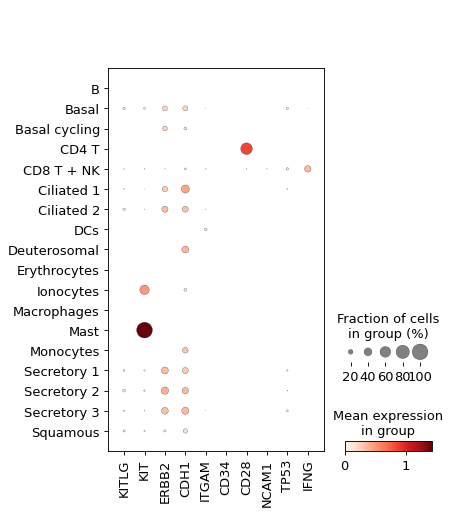

In [48]:
marker_genes = ['KITLG', 'KIT', 'ERBB2', 'CDH1', 'ITGAM',  'CD34', 'CD28', 'NCAM1', 'TP53','IFNG']
sc.pl.dotplot(ann, marker_genes, groupby='Annotation', save='Airwaycovid.svg')

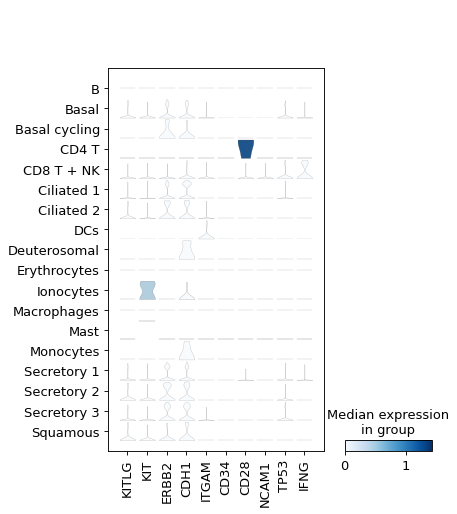

In [49]:
sc.pl.stacked_violin(ann, marker_genes, groupby='Annotation', rotation=90, save='Airwaycovid.svg')